## This is an implementation based on the Homework

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

In [22]:
def modify_geometry_parameters(model):
    # Modify link lengths (example: double the length of thigh and leg) MuJoCo uses capsules which is made up of [radius, hal-length]
    model.geom_size[1] = [0.05, 0.2, 0.]  # torso_geom: 
    model.geom_size[2], model.geom_size[5] = [0.05, 0.225, 0.], [0.05, 0.225, 0.]  # thigh_geom, thigh_left_geom : [radius, hal-length, 0.]
    model.geom_size[3], model.geom_size[6] = [0.04, 0.25, 0.], [0.04, 0.25, 0.]  # leg_geom, leg_left_geom: [radius, hal-length, 0.]
    model.geom_size[4], model.geom_size[7] = [0.06, 0.05, 0.], [0.06, 0.05, 0.]  # foot_geom, foot_left_geom: [radius, hal-length, 0.]

Walker2d requires a Gaussian policy with learned mean and variance.

Walker2d: 17D observation space, continuous 6D action space (Gaussian distribution).

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("Walker2d-v5")
model = env.unwrapped.model # Access the MuJoCo model
modify_geometry_parameters(model)
obs_dim = env.observation_space.shape[0]  # 17
act_dim = env.action_space.shape[0]  # 6

class ActorNet(nn.Module):
    def __init__(self, input_dim=obs_dim, output_dim=act_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, output_dim)
        self.log_std = nn.Parameter(torch.zeros(output_dim))  # Learnable log std

    def forward(self, s):
        x = F.relu(self.fc1(s))
        x = F.relu(self.fc2(x))
        mu = torch.tanh(self.mu(x))  # Actions in range (-1,1)
        std = torch.exp(self.log_std)  # Convert log_std to std
        return mu, std

class ValueNet(nn.Module):
    def __init__(self, input_dim=obs_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        x = F.relu(self.fc1(s))
        x = F.relu(self.fc2(x))
        return self.output(x)

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)

In [ ]:
gamma = 0.99
tau = 0.95  # GAE smoothing
clip_epsilon = 0.2
# These coefficients are experimentally determined in practice.
vf_coeff = 0.5  # weight coefficient for KL-divergence loss
kl_coeff = 0.2  # weight coefficient for value loss
lr = 3e-4

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)
optimizer = optim.Adam(list(actor_func.parameters()) + list(value_func.parameters()), lr=lr)
    
# Compute Generalized Advantage Estimation (GAE)
def compute_gae(rewards, values, gamma=0.99, tau=0.95):
    deltas = []
    for t in range(len(rewards)):  # Iterate over all rewards
        delta = rewards[t] + gamma * (values[t + 1] if t + 1 < len(values) else 0) - values[t] # Calculate the TD error (delta)
        deltas.append(delta)
    advantages = []
    adv = 0
    for delta in reversed(deltas):
        adv = delta + gamma * tau * adv
        advantages.insert(0, adv)
    return advantages

# Sampling function
def pick_sample_and_logp(s):
    with torch.no_grad():
        s = torch.tensor(s, dtype=torch.float, device=device).unsqueeze(0)
        mu, std = actor_func(s)
        dist = torch.distributions.Normal(mu, std)  # Used to sample continuous actions.
        action = dist.sample()
        action = torch.clamp(action, min=-1.0, max=1.0)
        # print(f"Sampled action: {action}")
        log_prob = dist.log_prob(action).sum(dim=-1)
        return action.squeeze(0).cpu().numpy(), log_prob.cpu().numpy()

reward_records = []
for episode in range(5000):
    done = False
    step_count = 0
    states, actions, log_probs, rewards = [], [], [], []
    s, _ = env.reset()
    
    while not done:
        states.append(s)
        a, logp = pick_sample_and_logp(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        actions.append(a)
        log_probs.append(logp)
        rewards.append(r)
        step_count += 1  # Increment step counter

    rewards = np.array(rewards)
    states = np.array(states)
    actions = np.array(actions)
    log_probs = np.array(log_probs)
    states = torch.tensor(states, dtype=torch.float, device=device)
    actions = torch.tensor(actions, dtype=torch.float, device=device)
    log_probs = torch.tensor(log_probs, dtype=torch.float, device=device)
    log_probs = log_probs.squeeze(dim=-1)  

    values = value_func(states).squeeze()
    advantages = compute_gae(rewards, values.detach().cpu().numpy())
    advantages = torch.tensor(advantages, dtype=torch.float, device=device)

    # Compute PPO loss
    mu, std = actor_func(states)
    dist = torch.distributions.Normal(mu, std)
    new_log_probs = dist.log_prob(actions).sum(dim=-1)

    # print("new_log_probs shape:", new_log_probs.shape)
    # print("log_probs shape:", log_probs.shape)
    ratio = torch.exp(new_log_probs - log_probs)
    # print("ratio shape:", ratio.shape)
    # print("advantages shape:", advantages.shape)
    surrogate = ratio * advantages
    clipped_surrogate = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
    policy_loss = -torch.min(surrogate, clipped_surrogate).mean()

    returns = advantages + values
    value_loss = F.mse_loss(value_func(states).squeeze(), returns.detach())
    
    loss = policy_loss + vf_coeff * value_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_reward = np.sum(rewards)
    reward_records.append(total_reward)

    print(f"Episode {episode}, Steps: {step_count}, Reward: {total_reward}", end="\r")

    if np.mean(reward_records[-50:]) > 4000:  # Stop condition for MuJoCo
        break

print("\nDone")
env.close()


Episode 4999, Steps: 266, Reward: 471.05850241540696
Done


In [29]:
torch.save(actor_func.state_dict(), "PPO_runs/ppo_walker2d_actor_5000episodes_099Discount_SmallerFeet.pth")

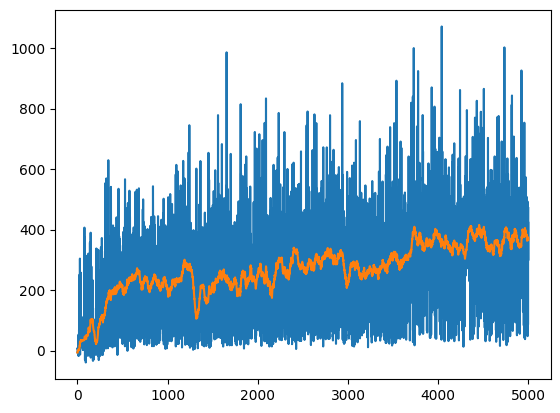

In [30]:
import matplotlib.pyplot as plt
# Generate recent 100 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 100:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)
plt.savefig("PPO_plots/5000Episodes_099Discount_SmallerFeet")

In [34]:
actor_func.load_state_dict(torch.load("PPO_runs/ppo_walker2d_actor_5000episodes_099Discount_SmallerFeet.pth"))
actor_func.eval()  # Set to evaluation mode

def visualize_walker(env_name="Walker2d-v5", episodes=10, render=True):
    env = gym.make(env_name, render_mode="human")  # Enable rendering
    model = env.unwrapped.model # Access the MuJoCo model
    modify_geometry_parameters(model)
    for episode in range(episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                mu, _ = actor_func(obs_tensor)
                action = mu.cpu().numpy().flatten()  # Convert to NumPy

            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            if render:
                env.render()  # Explicit rendering if required
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    env.close()

visualize_walker()

Episode 1: Total Reward = 457.52866719969154
Episode 2: Total Reward = 618.1957684273184
Episode 3: Total Reward = 811.1564033668654
Episode 4: Total Reward = 600.124958922742
Episode 5: Total Reward = 368.74357892794427
Episode 6: Total Reward = 801.971180337884
Episode 7: Total Reward = 564.7465802736757
Episode 8: Total Reward = 490.50849995104755
Episode 9: Total Reward = 496.852119040635
Episode 10: Total Reward = 355.6340444155931


In [8]:
import gymnasium as gym
env = gym.make("Walker2d-v5")
print(env.unwrapped.__doc__)  # This prints environment details


    ## Description
    This environment builds on the [hopper](https://gymnasium.farama.org/environments/mujoco/hopper/) environment by adding another set of legs that allow the robot to walk forward instead of hop.
    Like other MuJoCo environments, this environment aims to increase the number of independent state and control variables compared to classical control environments.
    The walker is a two-dimensional bipedal robot consisting of seven main body parts - a single torso at the top (with the two legs splitting after the torso), two thighs in the middle below the torso, two legs below the thighs, and two feet attached to the legs on which the entire body rests.
    The goal is to walk in the forward (right) direction by applying torque to the six hinges connecting the seven body parts.


    ## Action Space
    ```{figure} action_space_figures/walker2d.png
    :name: walker2d
    ```

    The action space is a `Box(-1, 1, (6,), float32)`. An action represents the torques app